In [29]:
import logging
import timm
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger('timm')
logger.setLevel(logging.WARNING)
import os
import shutil
import random
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
import albumentations as A
from sklearn.metrics import accuracy_score, f1_score
from PIL import Image
from tqdm import tqdm
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [30]:
PRE_PATH = '/kkh/'
META_KR_CSV_PATH = PRE_PATH + 'data/meta_kr.csv'
TRAIN_KR_IMAGE_PATH = PRE_PATH + 'data/train_kr'
TRAIN_KR_CSV_PATH = PRE_PATH + 'data/train_kr.csv'
TRAIN_KR_AUG_IMAGE_PATH = PRE_PATH + 'data/train_kr_aug_8_patch1_20'
TRAIN_KR_AUG_CSV_PATH = PRE_PATH + 'data/train_kr_aug_8_patch1_20.csv'
VALID_SUNHO_IMAGE_PATH = PRE_PATH + 'data/valid_sunho'
VALID_SUNHO_CSV_PATH = PRE_PATH + 'data/valid_sunho.csv'
TEST_IMAGE_PATH = PRE_PATH + 'data/test'
TEST_CSV_PATH = PRE_PATH + 'data/sample_submission.csv'
MODEL_SAVE_PATH = PRE_PATH + 'test/'

In [31]:
import gc
gc.collect()

torch.cuda.empty_cache()
torch.cuda.memory_reserved()
torch.cuda.memory_allocated()

137216

In [32]:
SEED = 38
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

MODEL_NAMES = ['efficientnet_b4']
NUM_EPOCHS = 50
EACH_MODEL_SAVE = True

PRETRAINED_SIZE = 380
PRETRAINED_MEANS = [0.485, 0.456, 0.406]
PRETRAINED_STDS = [0.229, 0.224, 0.225]

LR = 1e-3
BATCH_SIZE = 32
PATIENCE = 3
NUM_WORKERS = os.cpu_count()
NUM_CLASSES = 17

In [33]:
# 폴더 생성 및 백업
def prepare_folders():
    if os.path.exists(MODEL_SAVE_PATH):
        backup_path = PRE_PATH + 'test_backup/'
        shutil.move(MODEL_SAVE_PATH, backup_path)
        print(f"Existing '{MODEL_SAVE_PATH}' directory moved to '{backup_path}'.")

    os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

# Load Data
def load_data():
    meta_kr_df = pd.read_csv(META_KR_CSV_PATH)
    train_kr_df = pd.read_csv(TRAIN_KR_CSV_PATH)
    train_kr_aug_df = pd.read_csv(TRAIN_KR_AUG_CSV_PATH)
    valid_sunho_df = pd.read_csv(VALID_SUNHO_CSV_PATH)
    test_df = pd.read_csv(TEST_CSV_PATH)
    return meta_kr_df, train_kr_df, train_kr_aug_df, valid_sunho_df, test_df

In [34]:
# Dataset class 정의
class ImageDataset(Dataset):
    def __init__(self, df, image_path, transform=None, oversample=False):
        self.df = df
        self.image_path = image_path
        self.transform = transform
        self.oversample = oversample

        if self.oversample:
            class_counts = np.bincount(self.df['target'])
            max_class_count = max(class_counts)
            oversample_factors = [max_class_count // count for count in class_counts]

            oversampled_data = []
            for cls, factor in enumerate(oversample_factors):
                cls_data = self.df[self.df['target'] == cls]
                oversampled_data.append(cls_data.sample(factor * len(cls_data), replace=True))

            self.df = pd.concat(oversampled_data).reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df.iloc[idx]
        img = np.array(Image.open(os.path.join(self.image_path, name)).convert("RGB"))

        if self.transform:
            try:
                img = self.transform(image=img)['image']
            except Exception as e:
                print(f"Error in transforming image {name}: {e}")
                img = img

        return img, target

In [35]:
# 이미지 변환 설정
def get_transforms():
    train_transform = A.Compose([
        A.Resize(PRETRAINED_SIZE, PRETRAINED_SIZE),
        A.Normalize(mean=PRETRAINED_MEANS, std=PRETRAINED_STDS),
        ToTensorV2()
    ])

    valid_transform = A.Compose([
        A.Resize(PRETRAINED_SIZE, PRETRAINED_SIZE),
        A.Normalize(mean=PRETRAINED_MEANS, std=PRETRAINED_STDS),
        ToTensorV2()
    ])
    
    return train_transform, valid_transform

In [36]:
# 학습
def training(model, dataloader, criterion, optimizer, device, epoch, num_epochs, model_name):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(dataloader, desc=f"{model_name} - Training")
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        preds = model(images)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(labels.detach().cpu().numpy())

        pbar.set_description(f"{model_name} - Epoch [{epoch+1}/{num_epochs}] - Train Loss: {loss.item():.4f}")
        
    train_loss /= len(dataloader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')
    return model, train_loss, train_acc, train_f1, preds_list

In [37]:
# 평가
def evaluation(model, dataloader, criterion, device, epoch, num_epochs, model_name):
    model.eval()
    valid_loss = 0.0
    preds_list = []
    targets_list = []

    with torch.no_grad():
        tbar = tqdm(dataloader, desc=f"{model_name} - Evaluation")
        for images, labels in tbar:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)
            loss = criterion(preds, labels)

            valid_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
            targets_list.extend(labels.detach().cpu().numpy())
            tbar.set_description(f"{model_name} - Epoch [{epoch+1}/{num_epochs}] - Valid Loss: {loss.item():.4f}")

    valid_loss /= len(dataloader)
    valid_acc = accuracy_score(targets_list, preds_list)
    valid_f1 = f1_score(targets_list, preds_list, average='macro')
    print(f"{model_name} - Epoch [{epoch+1}/{num_epochs}] - Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}, Valid F1: {valid_f1:.4f}")

    return valid_loss, valid_acc, valid_f1, preds_list

In [38]:
# 학습 및 평가
def training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, device, num_epochs, patience, model_name):
    best_valid_f1 = -1
    early_stop_counter = 0
    best_model = None
    best_preds = []
    
    train_losses = []
    valid_losses = []
    train_f1s = []
    valid_f1s = []

    for epoch in range(num_epochs):
        model, train_loss, train_acc, train_f1, _ = training(model, train_dataloader, criterion, optimizer, device, epoch, num_epochs, model_name)
        valid_loss, valid_acc, valid_f1, valid_preds = evaluation(model, valid_dataloader, criterion, device, epoch, num_epochs, model_name)

        # 모델 저장
        if EACH_MODEL_SAVE:
            model_save_path = os.path.join(MODEL_SAVE_PATH, f"{model_name}_Ep{epoch+1}_L_{valid_loss:.4f}_A_{valid_acc:.4f}_F1_{valid_f1:.4f}.pt")
            torch.save(model.state_dict(), model_save_path)
            print(f"{model_name} - Saved Model to {model_save_path}")

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_f1s.append(train_f1)
        valid_f1s.append(valid_f1)

        if valid_f1 > best_valid_f1:
            best_valid_f1 = valid_f1
            best_model = model
            best_preds = valid_preds
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print(f"{model_name} - Early stopping triggered for {model_name} at epoch {epoch+1}")
            break

    return best_model, best_valid_f1, best_preds, train_losses, valid_losses, train_f1s, valid_f1s


In [39]:
# 앙상블 voting
def majority_voting_from_preds(preds_list):
    preds_array = np.array(preds_list)
    majority_preds = []

    for i in range(len(preds_array[0])):  # preds_array의 열 수를 기준으로 예측
        preds = preds_array[:, i]
        unique, counts = np.unique(preds, return_counts=True)
        chosen_pred = unique[np.argmax(counts)]
        if len(set(counts)) == 1:
            chosen_pred = preds[0]
        majority_preds.append(chosen_pred)
    
    return majority_preds

# 앙상블 평가
def evaluation_ensemble(dataloader, criterion, device, preds, model_name):
    targets_list = []

    with torch.no_grad():
        tbar = tqdm(dataloader, desc=f"{model_name} - Evaluation")
        for images, labels in tbar:
            labels = labels.to(device)
            targets_list.extend(labels.cpu().numpy())
            tbar.set_description(f"{model_name} - Valid Accuracy Calculation")
    valid_acc = accuracy_score(targets_list, preds)
    valid_f1 = f1_score(targets_list, preds, average='macro')
    print(f"{model_name} - Valid Acc: {valid_acc:.4f}, Valid F1: {valid_f1:.4f}")
    return valid_acc, valid_f1


In [40]:
# 최종 테스트 수행
def run_final_test(models, test_loader, test_df):
    all_preds = []
    for model in models:
        model.eval()
        preds_list = []

        with torch.no_grad():
            tbar = tqdm(test_loader, desc="Final Test")
            for images, _ in tbar:
                images = images.to(device)

                preds = model(images)
                preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

        all_preds.append(preds_list)
    
    ensemble_preds = majority_voting_from_preds(all_preds)
    
    test_df['target'] = ensemble_preds
    test_df.to_csv(os.path.join(MODEL_SAVE_PATH, 'test_predictions.csv'), index=False)
    print(f"Final test predictions saved to {os.path.join(MODEL_SAVE_PATH, 'test_predictions.csv')}")


In [41]:
def run_training_pipeline():
    prepare_folders()

    meta_kr_df, train_kr_df, train_kr_aug_df, valid_sunho_df, test_df = load_data()
    train_transform, valid_transform = get_transforms()

    train_dataset = ImageDataset(train_kr_aug_df, TRAIN_KR_AUG_IMAGE_PATH, transform=train_transform, oversample=True)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    valid_dataset = ImageDataset(valid_sunho_df, VALID_SUNHO_IMAGE_PATH, transform=valid_transform)
    valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    model_predictions = []
    valid_preds_list = []  
    all_train_losses = []
    all_valid_losses = []
    all_train_f1s = []
    all_valid_f1s = []

    for model_name in MODEL_NAMES:
        model = timm.create_model(model_name, pretrained=True, num_classes=NUM_CLASSES, in_chans=3)
        model = model.to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = Adam(model.parameters(), lr=LR)

        best_model, valid_max_f1, valid_preds, train_losses, valid_losses, train_f1s, valid_f1s = training_loop(
            model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=NUM_EPOCHS, patience=PATIENCE, model_name=model_name)
        
        model_predictions.append(best_model)
        valid_preds_list.append(valid_preds)
        
        all_train_losses.append(train_losses)
        all_valid_losses.append(valid_losses)
        all_train_f1s.append(train_f1s)
        all_valid_f1s.append(valid_f1s)

        # Save metrics to file
        np.savez(os.path.join(MODEL_SAVE_PATH, f'{model_name}_metrics.npz'),
                 train_losses=all_train_losses[-1],
                 valid_losses=all_valid_losses[-1],
                 train_f1s=all_train_f1s[-1],
                 valid_f1s=all_valid_f1s[-1])

    valid_preds_ensemble = majority_voting_from_preds(valid_preds_list)
    ensemble_valid_acc, ensemble_valid_f1 = evaluation_ensemble(valid_loader, criterion, device, valid_preds_ensemble, model_name="ensemble")
    ensemble_model_save_path = os.path.join(MODEL_SAVE_PATH, f"ensemble_A_{ensemble_valid_acc:.4f}_F1_{ensemble_valid_f1:.4f}")
    torch.save(model_predictions[0].state_dict(), ensemble_model_save_path)

    test_dataset = ImageDataset(test_df, TEST_IMAGE_PATH, transform=valid_transform)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    run_final_test(model_predictions, test_loader, test_df)

    print('=========================================================================================================')
    print('END!!!!!!')

In [42]:
run_training_pipeline()

Existing '/kkh/test/' directory moved to '/kkh/test_backup/'.


efficientnet_b4 - Epoch [1/50] - Train Loss: 0.0002: 100%|██████████| 5731/5731 [30:36<00:00,  3.12it/s]
efficientnet_b4 - Epoch [1/50] - Valid Loss: 0.1696: 100%|██████████| 10/10 [00:04<00:00,  2.15it/s]


efficientnet_b4 - Epoch [1/50] - Valid Loss: 0.3696, Valid Acc: 0.9122, Valid F1: 0.9100
efficientnet_b4 - Saved Model to /kkh/test/efficientnet_b4_Ep1_L_0.3696_A_0.9122_F1_0.9100.pt


efficientnet_b4 - Epoch [2/50] - Train Loss: 0.0098:  39%|███▉      | 2257/5731 [12:07<18:49,  3.08it/s]

In [ ]:
def plot_metrics_from_files():
    model_names = MODEL_NAMES
    all_train_losses = []
    all_valid_losses = []
    all_train_f1s = []
    all_valid_f1s = []

    # 데이터 로딩
    for model_name in model_names:
        metrics_file = os.path.join(MODEL_SAVE_PATH, f'{model_name}_metrics.npz')
        metrics = np.load(metrics_file)

        all_train_losses.append(metrics['train_losses'])
        all_valid_losses.append(metrics['valid_losses'])
        all_train_f1s.append(metrics['train_f1s'])
        all_valid_f1s.append(metrics['valid_f1s'])

    # 모델의 에포크 수 확인
    num_epochs = len(all_train_losses[0])  # Assuming all models have same number of epochs
    epochs = range(1, num_epochs + 1)

    def plot_metric(ax, metric_name, metric_data, ylabel, title):
        for i, model_name in enumerate(model_names):
            metric = metric_data[i]
            if len(metric) != num_epochs:
                print(f"Warning: Length mismatch for {model_name} - expected {num_epochs}, got {len(metric)}")
                if len(metric) > num_epochs:
                    metric = metric[:num_epochs]
                elif len(metric) < num_epochs:
                    metric = np.pad(metric, (0, num_epochs - len(metric)), 'constant', constant_values=np.nan)
            ax.plot(epochs, metric, label=f'{model_name} {metric_name}', color=plt.cm.viridis(i / len(model_names)))
        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.set_ylabel(ylabel)
        ax.legend()
        ax.grid(True)

    # Plot metrics
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))

    plot_metric(axs[0], 'Loss', all_train_losses, 'Loss', 'Train Loss')
    plot_metric(axs[1], 'Loss', all_valid_losses, 'Loss', 'Validation Loss')
    plot_metric(axs[2], 'F1 Score', all_train_f1s, 'F1 Score', 'Train F1 Score')
    plot_metric(axs[3], 'F1 Score', all_valid_f1s, 'F1 Score', 'Validation F1 Score')

    plt.tight_layout()
    plt.show()

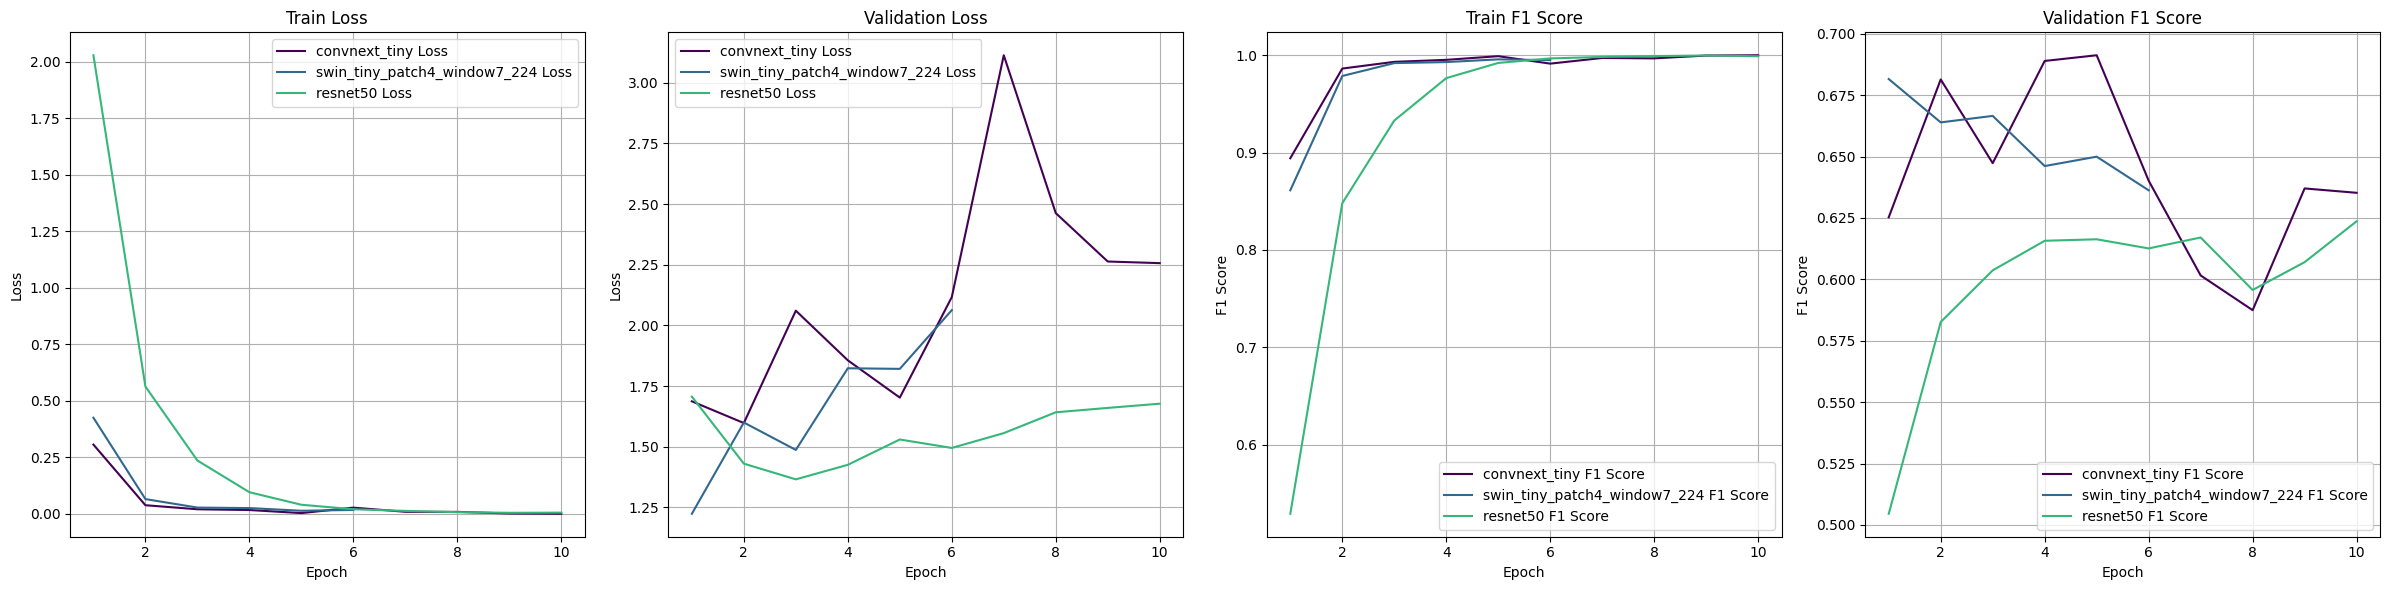

In [ ]:
plot_metrics_from_files()